## Experiment on @radek1's notebook on local validation framework

This notebook builds on my previous work -- [co-visitation matrix - simplified, imprvd logic 🔥](https://www.kaggle.com/code/radek1/co-visitation-matrix-simplified-imprvd-logic?scriptVersionId=110068977) that achieves 0.558 on the LB.

Here we take the functionality from that notebook, run on 1/1000 of the data (it achieves ~0.487 on public LB).

The next step in improving our results is to create a robust local validation framework to facilitate experimentation. This can be a stepping stone towards a much stronger result.

Let's take a stab at implementing a local validation framework in this notebook!

<strong>Please smash that thumbs up button if you like this notebook! Thank you! 🙂</strong>

In [1]:
import os

try: import fastkaggle
except ModuleNotFoundError:
    os.system("pip install -Uq fastkaggle")

from fastkaggle import *

# use fastdebug.utils 
if iskaggle: os.system("pip install nbdev snoop")

if iskaggle:
    path = "../input/fastdebugutils0"
    import sys
    sys.path
    sys.path.insert(1, path)
    import utils as fu
    from utils import *
else: 
    from fastdebug.utils import *
    import fastdebug.utils as fu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.1/64.1 kB 256.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 977.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 1.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
!pip install pickle5
import pickle5 as pickle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.4/256.4 kB 514.2 kB/s eta 0:00:00a 0:00:01


In [3]:
%%time
train = pd.read_parquet('../input/otto-full-optimized-memory-footprint/train.parquet')

CPU times: user 8.25 s, sys: 9.96 s, total: 18.2 s
Wall time: 19.2 s


### rd: recsys - otto - local validation - As we only use the last week of training set to split into the local test and local validation set
# test = pd.read_parquet('../input/otto-full-optimized-memory-footprint/test.parquet') 

In [4]:
DO_LOCAL_VALIDATION = True # set it True if we are doing local validation instead of submit to the public leaderboard

# Local CV

For local CV, we will use the last weeks data of train for validation.

Essentially, without modifying the calculations in the notebook, we can run evaluation locally if we replace the contents of the `train` and `test` variables.

When doing local validation, we will print out local results. And without it, we will train on full data and submit to Kaggle LB.

### rd: recsys - otto - local validation - Find the start and end datetime of training sessions

In [5]:
ts_min, ts_max = train.ts.min(), train.ts.max()
ts_min, ts_max

(1659304800, 1661723999)

### rd: recsys - otto - local validation - Version 2 of the Radek's dataset is second accuracy,`7*24*60*60` capture the length of actual 7 days; version 1 is millisecond accuracy and  using `7*24*60*60*1000` to capture 7 days length. see the accuracy difference in details [here](https://www.kaggle.com/code/danielliao/process-data-otto?scriptVersionId=111357696&cellId=29)

In [6]:
import datetime
datetime.date.fromtimestamp(ts_max), datetime.date.fromtimestamp(ts_max - 7*24*60*60), datetime.date.fromtimestamp(ts_max - 7*24*60*60*1000)

(datetime.date(2022, 8, 28),
 datetime.date(2022, 8, 21),
 datetime.date(2003, 6, 29))

### rd: recsys - otto - local validation - ts where to cut - train_cutoff = ts_max - seven_days # 1_056_923_999 = 1_661_723_999 - 604_800

In [7]:
seven_days = 7*24*60*60 # 604_800
train_cutoff = ts_max - seven_days # 1_056_923_999 = 1_661_723_999 - 604_800
ts_max > train_cutoff > ts_min

True

In [8]:
datetime.datetime.fromtimestamp(0), datetime.datetime.fromtimestamp(train_cutoff), \
datetime.datetime.fromtimestamp(ts_min), datetime.datetime.fromtimestamp(ts_max), \

(datetime.datetime(1970, 1, 1, 0, 0),
 datetime.datetime(2022, 8, 21, 21, 59, 59),
 datetime.datetime(2022, 7, 31, 22, 0),
 datetime.datetime(2022, 8, 28, 21, 59, 59))

### rd: recsys - otto - local validation - split train into local_train and local_test - local_train = train[train.ts <= train_cutoff] - local_test = train[train.ts > train_cutoff]

In [9]:
train.shape, train.memory_usage() # 216_716_096 rows

((216716096, 4),
 Index            128
 session    866864384
 aid        866864384
 ts         866864384
 type       216716096
 dtype: int64)

In [10]:
local_train = train[train.ts <= train_cutoff] # 163_955_181 rows, and RAM on session metrics doubled from 4.6G to 9.1G

In [11]:
# run
local_train.shape, local_train.memory_usage() # the Index is a huge number on RAM

((163955181, 4),
 Index      1311641448
 session     655820724
 aid         655820724
 ts          655820724
 type        163955181
 dtype: int64)

In [12]:
# run
local_test = train[train.ts > train_cutoff] # 52_760_915 rows, and RAM raise from 9.1G to 10.1G

In [13]:
# run 
local_test.shape, local_test.memory_usage() # the Index is a huge number on RAM

((52760915, 4),
 Index      422087320
 session    211043660
 aid        211043660
 ts         211043660
 type        52760915
 dtype: int64)

### rd: recsys - otto - local validation - How train.reset_index work? - help(train.reset_index) 

In [14]:
# help(train.reset_index) 
#     >>> df = pd.DataFrame([('bird', 389.0),
#     ...                    ('bird', 24.0),
#     ...                    ('mammal', 80.5),
#     ...                    ('mammal', np.nan)],
#     ...                   index=['falcon', 'parrot', 'lion', 'monkey'],
#     ...                   columns=('class', 'max_speed'))
#     >>> df
#              class  max_speed
#     falcon    bird      389.0
#     parrot    bird       24.0
#     lion    mammal       80.5
#     monkey  mammal        NaN
    
#     When we reset the index, the old index is added as a column, and a
#     new sequential index is used:
    
#     >>> df.reset_index()
#         index   class  max_speed
#     0  falcon    bird      389.0
#     1  parrot    bird       24.0
#     2    lion  mammal       80.5
#     3  monkey  mammal        NaN
    
#     We can use the `drop` parameter to avoid the old index being added as
#     a column:
    
#     >>> df.reset_index(drop=True)
#         class  max_speed
#     0    bird      389.0
#     1    bird       24.0
#     2  mammal       80.5
#     3  mammal        NaN

### rd: recsys - otto - local validation - Save RAM by converting local_train.index from Int64Index to RangeIndex like train.index? - train.index, local_train.index, local_test.index - local_train.reset_index(inplace=True, drop=True)
https://stackoverflow.com/questions/54603378/pandas-convert-from-int64index-to-rangeindex

In [15]:
train.index, local_train.index, local_test.index # RangeIndex vs Int64Index

(RangeIndex(start=0, stop=216716096, step=1),
 Int64Index([        0,         1,         2,         3,         4,         5,
                     6,         7,         8,         9,
             ...
             201331366, 201331419, 201331437, 201331440, 201331459, 201331461,
             201331464, 201331469, 201331485, 201331512],
            dtype='int64', length=163955181),
 Int64Index([      147,       148,       149,       150,       151,       152,
                   153,       154,       155,       156,
             ...
             216716086, 216716087, 216716088, 216716089, 216716090, 216716091,
             216716092, 216716093, 216716094, 216716095],
            dtype='int64', length=52760915))

### convert index from Int64Range to RangeIndex

In [16]:
local_train.reset_index(inplace=True, drop=True) # no effect on RAM from the session metrics board
local_train.index, local_train.memory_usage() # but the number for Index dropped drastically
# previously the local_train.index RAM usage is 1311641448, now is 128

(RangeIndex(start=0, stop=163955181, step=1),
 Index            128
 session    655820724
 aid        655820724
 ts         655820724
 type       163955181
 dtype: int64)

In [17]:
local_test.reset_index(inplace=True, drop=True) # no effect on RAM from the session metrics board
local_test.index, local_test.memory_usage() # but the number for Index dropped drastically
# the previous RAM usage of local_test.index is 422087320

(RangeIndex(start=0, stop=52760915, step=1),
 Index            128
 session    211043660
 aid        211043660
 ts         211043660
 type        52760915
 dtype: int64)

In [18]:
del train # RAM dropped from 10.1G to 7.5G according to session metrics

### rd: recsys - otto - local validation - what are the benefits of removing intersecting sessions between local_train and local_test to simulate real world - overlapping_sessions = set(local_train.session).intersection(set(local_test.session))

In [19]:
%%time
overlapping_sessions = set(local_train.session).intersection(set(local_test.session)) # not use use RAM

CPU times: user 25.8 s, sys: 2.04 s, total: 27.8 s
Wall time: 27.6 s


### rd: recsys - otto - local validation - the portion of intersection sessions on local_train and local_test is large. What would happen when adding those sessions back? better score or worse score? (question)

In [20]:
len(overlapping_sessions), len(overlapping_sessions)/local_train.session.unique().shape[0], len(overlapping_sessions)/local_test.session.unique().shape[0]

# 3_521_833, 11_098_528, 5_323_084

(3521833, 0.31732433346115807, 0.6616151464076088)

In [21]:
%%time
local_test = local_test[~local_test.session.isin(overlapping_sessions)] # RAM raise from 7.5 to 7.9
local_test.index, local_test.memory_usage()

CPU times: user 1.98 s, sys: 362 ms, total: 2.35 s
Wall time: 2.34 s


(Int64Index([37376338, 37376339, 37376340, 37376341, 37376342, 37376343,
             37376344, 37376345, 37376346, 37376347,
             ...
             52760905, 52760906, 52760907, 52760908, 52760909, 52760910,
             52760911, 52760912, 52760913, 52760914],
            dtype='int64', length=15384577),
 Index      123076616
 session     61538308
 aid         61538308
 ts          61538308
 type        15384577
 dtype: int64)

In [22]:
local_test.reset_index(inplace=True, drop=True) # but not reduce RAM according to session metrics, stays at 7.9G
local_test.index, local_test.memory_usage()

(RangeIndex(start=0, stop=15384577, step=1),
 Index           128
 session    61538308
 aid        61538308
 ts         61538308
 type       15384577
 dtype: int64)

### rd: recsys - otto - local validation - any empty rows in any sessions of local_test - local_test.groupby('session')['aid'].count().apply(lambda x: x == 0)

In [23]:

count_zero = local_test.groupby('session')['aid'].count().apply(lambda x: x == 0)
count_one = local_test.groupby('session')['aid'].count().apply(lambda x: x > 0)

In [24]:
sum(count_zero), sum(count_one), local_test.session.unique().shape[0]

(0, 1801251, 1801251)

### rd: recsys - otto - local validation - split local_test into test and validation two parts - for grp in local_test.groupby('session'): -     cutoff = np.random.randint(1, grp[1].shape[0]) - new_test.append(grp[1].iloc[:cutoff]) -     data_to_calculate_validation_score.append(grp[1].iloc[cutoff:])

In [25]:
%%time
new_test = []
data_to_calculate_validation_score = []

for grp in local_test.groupby('session'): # loop each session of local_test
    # select a random row from the session as cutoff row, we want at least a single item in our validation data for each session
    cutoff = np.random.randint(1, grp[1].shape[0]) 
    new_test.append(grp[1].iloc[:cutoff]) # take the left part from cutoff as data samples for local test
    data_to_calculate_validation_score.append(grp[1].iloc[cutoff:]) # take the right part from the cutoff as data samples for local validation

CPU times: user 2min 48s, sys: 6.76 s, total: 2min 55s
Wall time: 2min 55s


### rd: recsys - otto - local validation - stack a list of smaller dfs onto each other - test = pd.concat(new_test).reset_index(drop=True) - valid = pd.concat(data_to_calculate_validation_score).reset_index(drop=True)

In [29]:
%%time
test = pd.concat(new_test).reset_index(drop=True) # stack a list of smaller dfs onto each otehr
valid = pd.concat(data_to_calculate_validation_score).reset_index(drop=True) # maximum to 24G

CPU times: user 5min 45s, sys: 12 s, total: 5min 57s
Wall time: 5min 57s


In [30]:
test.shape, test.memory_usage(), valid.shape, valid.memory_usage()

((7697659, 4),
 Index           128
 session    30790636
 aid        30790636
 ts         30790636
 type        7697659
 dtype: int64,
 (7686918, 4),
 Index           128
 session    30747672
 aid        30747672
 ts         30747672
 type        7686918
 dtype: int64)

In [31]:
%%time
test.to_parquet('_test.parquet') # save to a parquet file
valid.to_parquet('_valid.parquet')

del new_test, data_to_calculate_validation_score # now dropped to 9.8G

CPU times: user 16.7 s, sys: 2.14 s, total: 18.8 s
Wall time: 18.8 s


In [32]:
del local_test # from 9.8G down to 9.3G according to session metrics

In [33]:
train = local_train

In [34]:
DO_LOCAL_VALIDATION = True

We have now swapped the train and test sets for the ones we conjured and can now proceed to train as we would normally.

# Train

### rd: recsys - otto - local validation - create subset on both train and test - lucky_sessions_train = train.drop_duplicates(['session']).sample(frac=fraction_of_sessions_to_use)['session'] - subset_of_train = train[train.session.isin(lucky_sessions_train)]

In [35]:
fraction_of_sessions_to_use = 1/1000

In [36]:
%%time

lucky_sessions_train = train.drop_duplicates(['session']).sample(frac=fraction_of_sessions_to_use)['session']
subset_of_train = train[train.session.isin(lucky_sessions_train)]

lucky_sessions_test = test.drop_duplicates(['session']).sample(frac=fraction_of_sessions_to_use)['session']
subset_of_test = test[test.session.isin(lucky_sessions_test)]

# now session metrics reports RAM to be 10.5GB

CPU times: user 8.53 s, sys: 929 ms, total: 9.46 s
Wall time: 9.46 s


### rd: recsys - otto - local validation - Add session as index for the subsets (train and test) - subset_of_train.index = pd.MultiIndex.from_frame(subset_of_train[['session']])

In [37]:
subset_of_train.index = pd.MultiIndex.from_frame(subset_of_train[['session']])
subset_of_test.index = pd.MultiIndex.from_frame(subset_of_test[['session']]) # now effect on RAM

In [38]:
subset_of_train.shape, subset_of_train.session.unique().shape[0], subset_of_test.shape, subset_of_test.session.unique().shape[0],

((166101, 4), 11099, (7768, 4), 1801)

### rd: recsys - otto - local validation - each the last 30 events of each session, make a cartesian product on each event, remove rows with the same aids, only select rows two aids occurred consecutively within a day, and doing it in large chunk/batch of sessions each loop, put each chunk of sessions as an item into a list (see src below)

In [39]:
%%time

all_consecutive_AIDs = [] 
chunk_size = 60_000

sessions = subset_of_train.session.unique() # all unique sessions of subset_of_train
for i in range(0, sessions.shape[0], chunk_size): # loop every 60_000 sessions, not rows (each session has multiple rows)
    # take every 60_000 sessions (with all rows in each session) put into a new df named current_chunk (also remove session as index)
    current_chunk = subset_of_train.loc[sessions[i]:sessions[min(sessions.shape[0]-1, i+chunk_size-1)]].reset_index(drop=True)
    # update current_chunk by selecting the last 30 rows of each session (make sure no additional index)
    current_chunk = current_chunk.groupby('session').apply(lambda g: g.tail(30)).reset_index(drop=True)
    # @radek1 has a nice explanation on this line of code, see the cell below
    # consecutive_AIDs contains 60_000 sessions, each aid has paired with every aids    
    consecutive_AIDs = current_chunk.merge(current_chunk, on='session')
    # remove all rows where the pair of aids are the same
    consecutive_AIDs = consecutive_AIDs[consecutive_AIDs.aid_x != consecutive_AIDs.aid_y]
    # add a column named 'days_elapsed' to record how many days passed between two aids
    # whether divided by 1000 or not should make no difference in RAM, as they are all float64 type
    consecutive_AIDs['days_elapsed'] = (consecutive_AIDs.ts_y - consecutive_AIDs.ts_x) / (24 * 60 * 60) # not 24*60*60*1000
    # select only rows where first aid comes before second aid and both occurred in the same day
    consecutive_AIDs = consecutive_AIDs[(consecutive_AIDs.days_elapsed > 0) & (consecutive_AIDs.days_elapsed <= 1)]
    # put every 60_000 session df processed above into a list
    all_consecutive_AIDs.append(
        consecutive_AIDs
    )

CPU times: user 3.63 s, sys: 75.1 ms, total: 3.7 s
Wall time: 3.69 s


#### How @radek1 explains `current_chunk.merge(current_chunk, on='session')` above from [discussion](https://www.kaggle.com/code/radek1/co-visitation-matrix-simplified-imprvd-logic/comments#2031136)
so that we can create a cartesian product of aids

essentially, it is a trick to create aid pairs by session

if a user had three aids in a session 1, 2, 3 this will create all possible pairs [1, 1], [1,2], [1,3], [2,1]… etc

### rd: recsys - otto - local validaiton - apply the same logic above to the subset_of_test, and append them to consecutive_AIDs which is the same list that stores sessions in subset_of_train (see src)

In [40]:
%%time
sessions = subset_of_test.session.unique()
for i in range(0, sessions.shape[0], chunk_size):
    current_chunk = subset_of_test.loc[sessions[i]:sessions[min(sessions.shape[0]-1, i+chunk_size-1)]].reset_index(drop=True)
    current_chunk = current_chunk.groupby('session').apply(lambda g: g.tail(30)).reset_index(drop=True)
    consecutive_AIDs = current_chunk.merge(current_chunk, on='session')
    consecutive_AIDs = consecutive_AIDs[consecutive_AIDs.aid_x != consecutive_AIDs.aid_y]
    consecutive_AIDs['days_elapsed'] = (consecutive_AIDs.ts_y - consecutive_AIDs.ts_x) / (24 * 60 * 60 * 1000)
    consecutive_AIDs = consecutive_AIDs[(consecutive_AIDs.days_elapsed > 0) & (consecutive_AIDs.days_elapsed <= 1)]
    all_consecutive_AIDs.append(
        consecutive_AIDs
    )

CPU times: user 519 ms, sys: 9 ms, total: 528 ms
Wall time: 526 ms


### rd: recsys - otto - local validation - check the rows with duplicated values on 3 specified columns - all_yet.duplicated(['session', 'aid_x', 'aid_y']) - and remove rows from the dataframe - all_yet.drop_duplicates(['session', 'aid_x', 'aid_y'])

In [41]:
all_yet = pd.concat(all_consecutive_AIDs)

In [42]:
all_yet.head()

,session,aid_x,ts_x,type_x,aid_y,ts_y,type_y,days_elapsed
1,1890,1762221,1661025907,1,1314229,1661025934,0,0.000313
2,1890,1762221,1661025907,1,1192169,1661025984,0,0.000891
3,1890,1762221,1661025907,1,1679496,1661025992,0,0.000984
4,1890,1762221,1661025907,1,110964,1661033953,0,0.093125
5,1890,1762221,1661025907,1,1497089,1661036167,0,0.118750


In [82]:
all_yet.duplicated(['session', 'aid_x', 'aid_y']).sum(), all_yet.shape[0]
all_yet.drop_duplicates(['session', 'aid_x', 'aid_y']).shape
all_yet[all_yet.duplicated(['session', 'aid_x', 'aid_y'])]

(279968, 596003)

(316035, 8)

,session,aid_x,ts_x,type_x,aid_y,ts_y,type_y,days_elapsed
6,1890,1762221,1661025907,1,1497089,1661036243,0,1.196296e-01
10,1890,1762221,1661025907,1,1497089,1661036518,0,1.228125e-01
22,1890,1762221,1661025907,1,398187,1661038376,0,1.443171e-01
25,1890,1762221,1661025907,1,1134003,1661038424,1,1.448727e-01
26,1890,1762221,1661025907,1,1134003,1661038448,0,1.451505e-01
...,...,...,...,...,...,...,...,...
76758,12897907,340856,1661722799,0,1253057,1661722973,0,2.013889e-06
76765,12897907,731037,1661722926,0,1253057,1661722973,0,5.439815e-07
76780,12897907,1253057,1661722973,0,1696378,1661722992,0,2.199074e-07
76781,12897907,1253057,1661722973,0,1011104,1661723010,0,4.282407e-07


In [86]:
dup = all_yet[all_yet.duplicated(['session', 'aid_x', 'aid_y'])]
dup1 = dup.loc[dup.aid_y == 398187]
dup1.loc[dup1.aid_x == 1762221]

,session,aid_x,ts_x,type_x,aid_y,ts_y,type_y,days_elapsed
22,1890,1762221,1661025907,1,398187,1661038376,0,0.144317
28,1890,1762221,1661025907,1,398187,1661038704,0,0.148113


### rd: recsys - otto - local validation - question - selection with two conditionals - all_yet.loc[(all_yet.session == 1890 & all_yet.aid_x == 1762221), :]

In [87]:
# all_yet.loc[(all_yet.session == 1890 & all_yet.aid_x == 1762221), :] # 

### rd: recsys - otto - local validation - stack all dfs inside all_consecutive_AIDs into a single df and remove the rows when their session, aid_x, aid_y are the same - all_consecutive_AIDs = pd.concat(all_consecutive_AIDs).drop_duplicates(['session', 'aid_x', 'aid_y'])[['aid_x', 'aid_y']]

In [89]:
%%time
all_consecutive_AIDs = pd.concat(all_consecutive_AIDs).drop_duplicates(['session', 'aid_x', 'aid_y'])[['aid_x', 'aid_y']]

CPU times: user 99.6 ms, sys: 14 ms, total: 114 ms
Wall time: 112 ms


In [90]:
all_consecutive_AIDs.head()

,aid_x,aid_y
1,1762221,1314229
2,1762221,1192169
3,1762221,1679496
4,1762221,110964
5,1762221,1497089


### rd: recsys - otto - local validation - across all sessions, for each (aid_x, aid_y) pair, count and accumulate the occurrences of aid_y - next_AIDs = defaultdict(Counter) - for row in all_consecutive_AIDs.itertuples(): - next_AIDs[row.aid_x][row.aid_y] += 1

In [91]:
%%time

from collections import defaultdict, Counter

next_AIDs = defaultdict(Counter)

for row in all_consecutive_AIDs.itertuples():
    next_AIDs[row.aid_x][row.aid_y] += 1

CPU times: user 625 ms, sys: 24.9 ms, total: 650 ms
Wall time: 648 ms


In [92]:
for k,v in next_AIDs.items(): 
    print(k)
    print(v)
    break

1762221
Counter({1314229: 1, 1192169: 1, 1679496: 1, 110964: 1, 1497089: 1, 1441150: 1, 1509820: 1, 1077363: 1, 307558: 1, 398187: 1, 141736: 1, 824944: 1, 505035: 1, 1460571: 1, 1109824: 1, 759436: 1, 951283: 1, 1324356: 1, 1255532: 1, 549194: 1, 1134003: 1, 1162414: 1})


In [95]:
len(next_AIDs), all_consecutive_AIDs.aid_x.unique().shape[0]

(46188, 46188)

## rd: recsys - otto - local validation - Now let's generate the predictions or labels from test set and validation set is to provide ground truth - get all aids of each test session into a list - test_session_AIDs = test.groupby('session')['aid'].apply(list)

In [97]:
%%time
# get aid into a list for every session in the processed local_test
test_session_AIDs = test.groupby('session')['aid'].apply(list)
test_session_AIDs.head()

CPU times: user 32.2 s, sys: 1.4 s, total: 33.7 s
Wall time: 33.7 s


session
11098528    [11830, 1679529, 92401, 1055218, 1561739, 1679529, 1033148, 440367, 11830, 1033148, 1679529, 1199737, 1199737, 990658, 1033148, 11830, 440367, 369774, 907564, 1199737, 1462506, 950341, 1561739, 92401]
11098529                                                                                                                                                                                                   [1105029]
11098530                                                                                                                                                            [264500, 264500, 409236, 409236, 409236, 409236]
11098531                                                                                                                                                         [452188, 1239060, 1557766, 452188, 396199, 1309633]
11098532                                                                                                                                    

### rd: recsys - otto - robust local validation - debug a block of code by making it a func and use print and return

**The original code** here and see debuggable version in the next cell
```python
labels = []

for AIDs in test_session_AIDs: # loop each session to get its list of aids
    AIDs = list(dict.fromkeys(AIDs[::-1])) # reverse the order of the list of aids and remove duplicated aids and return a list
    if len(AIDs) >= 20: # if there are more than 20 aids in the session, then takes the first 20 aids into labels (a list)
        labels.append(AIDs[:20])
    else:
        counter = Counter()
        for AID in AIDs: # loop every aid of the list of aid from the session
            subsequent_AID_counter = next_AIDs.get(AID) # use next_AIDs to access all the pair partners of AID, which is a counter
            # if the counter exist, merge subsequent_AID_counter to counter (counter is still a single counter with a lot more items each time)
            if subsequent_AID_counter:
                counter += subsequent_AID_counter
        # now, counter is a Counter contains a Counter of other aids for every aid in a session (which means a lot of other aids counts)
        # take the 40 most common other aids, if they are not already in AIDs, then add them to AIDs
        AIDs += [AID for AID, cnt in counter.most_common(40) if AID not in AIDs]
        # in the end only take the first 20 aids into labels for each session
        labels.append(AIDs[:20])
```

### rd: recsys - otto - local validation - create the labels/predictions for each test session/user - reverse the list of aids of each session, remove the duplicated aids, and select the first 20 aids as labels - and save it into a list 'labels' - question: should we use the learning from training set here? (see src below)

### rd: recsys - otto - local validation - if there are less than 20 aids in each session then we can borrow aids from next_AIDs which is learnt from training - get all aid_ys for each aid of a test session - find 40 the most common aid_ys - if they are not already exist in the test session, then add them into the list of aids of the test session - then take the first 20 from the new list of aids of the test session (see src below)

In [98]:
%%time
def f():
    labels = []

    for AIDs in test_session_AIDs: # loop each session to get its list of aids
        AIDs = list(dict.fromkeys(AIDs[::-1])) # reverse the order of the list of aids and remove duplicated aids and return a list
        if len(AIDs) >= 20: # if there are more than 20 aids in the session, then takes the first 20 aids into labels (a list)
            labels.append(AIDs[:20])
        else:
            counter = Counter()
#             idx = 0
            for AID in AIDs: # loop every aid of the list of aid from the session
                subsequent_AID_counter = next_AIDs.get(AID) # use next_AIDs to access all the pair partners of AID, which is a counter
                # if the counter exist, merge subsequent_AID_counter to counter (counter is still a single counter with a lot more items each time)
                if subsequent_AID_counter:
#                     idx+=1
                    counter += subsequent_AID_counter
#                     print(f"subsequent_AID_counter: {subsequent_AID_counter}")
#                     print(f"counter: {counter}")
#                     print()
#                     if idx>1:
#                         return

            # now, counter is a Counter contains a Counter of other aids for every aid in a session (which means a lot of other aids counts)
            # take the 40 most common other aids, if they are not already in AIDs, then add them to AIDs
#             print(counter.most_common(40))
#             help(counter.most_common)
#             return
            AIDs += [AID for AID, cnt in counter.most_common(40) if AID not in AIDs]
            # in the end only take the first 20 aids into labels for each session
            labels.append(AIDs[:20])
    
    return labels

labels = f()

CPU times: user 43.8 s, sys: 731 ms, total: 44.5 s
Wall time: 44.5 s


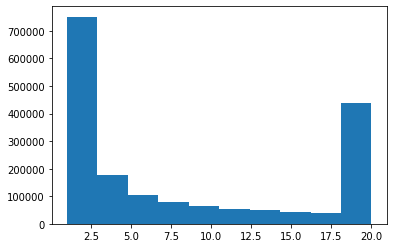

In [99]:
from matplotlib import pyplot as plt

plt.hist([len(l) for l in labels]);

## Prepare the submission format

### rd: recsys - otto - local validation - make the list of aids into a string - labels_as_strings = [' '.join([str(l) for l in lls]) for lls in labels] - make a df from a dict of lists - predictions = pd.DataFrame(data={'session_type': test_session_AIDs.index, 'labels': labels_as_strings})

In [100]:
labels_as_strings = [' '.join([str(l) for l in lls]) for lls in labels]
predictions = pd.DataFrame(data={'session_type': test_session_AIDs.index, 'labels': labels_as_strings})
labels_as_strings[:2]
predictions.head()

['92401 1561739 950341 1462506 1199737 907564 369774 440367 11830 1033148 990658 1679529 1055218 170669 834015 1146755 1503610 405331 425885 681918',
 '1105029']

,session_type,labels
0,11098528,92401 1561739 950341 1462506 1199737 907564 369774 440367 11830 1033148 990658 1679529 1055218 170669 834015 1146755 1503610 405331 425885 681918
1,11098529,1105029
2,11098530,409236 264500 583026 335674 1604904 237586 805787 1603001 364155 877496 752334 1677181 899408 292767
3,11098531,1309633 396199 452188 1557766 1239060
4,11098532,1089 108125 461190 1308930 1550739 1596491 876469 7651 435253 1557927 659399 174981 39615 830550 612920 738098 511499 360420 1402537 695824


### rd: recsys - ottp - local validation - make predictions/labels for clicks, carts and orders (no difference) - and prepare and create the submission dataframe

In [101]:
prediction_dfs = []
session_types = ['clicks', 'carts', 'orders']

for st in session_types:
    modified_predictions = predictions.copy()
    modified_predictions.session_type = modified_predictions.session_type.astype('str') + f'_{st}'
    prediction_dfs.append(modified_predictions)

In [102]:
prediction_dfs[0].head()

,session_type,labels
0,11098528_clicks,92401 1561739 950341 1462506 1199737 907564 369774 440367 11830 1033148 990658 1679529 1055218 170669 834015 1146755 1503610 405331 425885 681918
1,11098529_clicks,1105029
2,11098530_clicks,409236 264500 583026 335674 1604904 237586 805787 1603001 364155 877496 752334 1677181 899408 292767
3,11098531_clicks,1309633 396199 452188 1557766 1239060
4,11098532_clicks,1089 108125 461190 1308930 1550739 1596491 876469 7651 435253 1557927 659399 174981 39615 830550 612920 738098 511499 360420 1402537 695824


In [103]:
prediction_dfs[1].head()

,session_type,labels
0,11098528_carts,92401 1561739 950341 1462506 1199737 907564 369774 440367 11830 1033148 990658 1679529 1055218 170669 834015 1146755 1503610 405331 425885 681918
1,11098529_carts,1105029
2,11098530_carts,409236 264500 583026 335674 1604904 237586 805787 1603001 364155 877496 752334 1677181 899408 292767
3,11098531_carts,1309633 396199 452188 1557766 1239060
4,11098532_carts,1089 108125 461190 1308930 1550739 1596491 876469 7651 435253 1557927 659399 174981 39615 830550 612920 738098 511499 360420 1402537 695824


In [104]:
prediction_dfs[2].head()

,session_type,labels
0,11098528_orders,92401 1561739 950341 1462506 1199737 907564 369774 440367 11830 1033148 990658 1679529 1055218 170669 834015 1146755 1503610 405331 425885 681918
1,11098529_orders,1105029
2,11098530_orders,409236 264500 583026 335674 1604904 237586 805787 1603001 364155 877496 752334 1677181 899408 292767
3,11098531_orders,1309633 396199 452188 1557766 1239060
4,11098532_orders,1089 108125 461190 1308930 1550739 1596491 876469 7651 435253 1557927 659399 174981 39615 830550 612920 738098 511499 360420 1402537 695824


In [105]:
submission = pd.concat(prediction_dfs).reset_index(drop=True)
submission.head()

,session_type,labels
0,11098528_clicks,92401 1561739 950341 1462506 1199737 907564 369774 440367 11830 1033148 990658 1679529 1055218 170669 834015 1146755 1503610 405331 425885 681918
1,11098529_clicks,1105029
2,11098530_clicks,409236 264500 583026 335674 1604904 237586 805787 1603001 364155 877496 752334 1677181 899408 292767
3,11098531_clicks,1309633 396199 452188 1557766 1239060
4,11098532_clicks,1089 108125 461190 1308930 1550739 1596491 876469 7651 435253 1557927 659399 174981 39615 830550 612920 738098 511499 360420 1402537 695824


# We either submit to Kaggle or run validation locally

We need to now reverse the processing we applied to our predictions to shape them into a submission.

I am undoing this work here on purpose. I will replace the code I use for predictions down the road, so I want my evaluation framework to work with data formatted like for making a submission.

### rd: load id2type dict and type2id list from pickle file

In [106]:
with open('../input/otto-full-optimized-memory-footprint/id2type.pkl', "rb") as fh:
    id2type = pickle.load(fh)
with open('../input/otto-full-optimized-memory-footprint/type2id.pkl', "rb") as fh:
    type2id = pickle.load(fh)
    
sample_sub = pd.read_csv('../input/otto-recommender-system/sample_submission.csv')

In [107]:
sample_sub.head()

,session_type,labels
0,12899779_clicks,129004 126836 118524
1,12899779_carts,129004 126836 118524
2,12899779_orders,129004 126836 118524
3,12899780_clicks,129004 126836 118524
4,12899780_carts,129004 126836 118524


### rd: validation set and test set must be in the same session so that we can use test set to make predictions and validaiton set can provide ground truth to compare against

```python
%%time
if DO_LOCAL_VALIDATION:
    # convert back for experiment
    submission['session'] = submission.session_type.apply(lambda x: int(x.split('_')[0]))
    submission['type'] = submission.session_type.apply(lambda x: x.split('_')[1])
    submission.labels = submission.labels.apply(lambda x: [int(i) for i in x.split(' ')])

    # convert type from idx to string-type for validation set
    valid.type = valid.type.map(lambda idx: id2type[idx])
    # group by session, then group by type, to access all aids, and make all aids into a list
    ground_truth = valid.groupby(['session', 'type'])['aid'].apply(list)
    # remove index and rename column aid to labels
    ground_truth = ground_truth.reset_index().rename(columns={'aid': 'labels'})
    # 
    ground_truth.loc[ground_truth.type == 'clicks', 'labels'] = ground_truth.loc[ground_truth.type == 'clicks', 'labels'].str[-1:]

    submission_with_gt = submission.merge(ground_truth[['session', 'type', 'labels']], how='left', on=['session', 'type'])
    submission_with_gt = submission_with_gt[~submission_with_gt.labels_y.isna()]
    submission_with_gt['hits'] = submission_with_gt.apply(lambda df: len(set(df.labels_x).intersection(set(df.labels_y))), axis=1)
    submission_with_gt['gt_count'] = submission_with_gt.labels_y.str.len()

    recall_per_type = submission_with_gt.groupby(['type'])['hits'].sum() / submission_with_gt.groupby(['type'])['gt_count'].sum() 
    local_validation_score = (recall_per_type * pd.Series({'clicks': 0.10, 'carts': 0.30, 'orders': 0.60})).sum()
    print(f'Local validation score: {local_validation_score}')

else:
    submission.to_csv('submission.csv', index=False)
```

## Experiment to figure what some lines do

In [109]:
submission = pd.concat(prediction_dfs).reset_index(drop=True)
submission.head()

,session_type,labels
0,11098528_clicks,92401 1561739 950341 1462506 1199737 907564 369774 440367 11830 1033148 990658 1679529 1055218 170669 834015 1146755 1503610 405331 425885 681918
1,11098529_clicks,1105029
2,11098530_clicks,409236 264500 583026 335674 1604904 237586 805787 1603001 364155 877496 752334 1677181 899408 292767
3,11098531_clicks,1309633 396199 452188 1557766 1239060
4,11098532_clicks,1089 108125 461190 1308930 1550739 1596491 876469 7651 435253 1557927 659399 174981 39615 830550 612920 738098 511499 360420 1402537 695824


In [ ]:

def f():
    if DO_LOCAL_VALIDATION:
        # convert back for experiment
        submission['session'] = submission.session_type.apply(lambda x: int(x.split('_')[0]))
        submission['type'] = submission.session_type.apply(lambda x: x.split('_')[1])
        submission.labels = submission.labels.apply(lambda x: [int(i) for i in x.split(' ')])

        # convert type from idx to string-type for validation set
        valid.type = valid.type.map(lambda idx: id2type[idx])
        # group by session, then group by type, to access all aids, and make all aids into a list
        ground_truth = valid.groupby(['session', 'type'])['aid'].apply(list)
#         print(ground_truth)
#         return
        # remove index and rename column aid to labels (no more aid as column)
        ground_truth = ground_truth.reset_index().rename(columns={'aid': 'labels'})
#         print(ground_truth)
#         return
        # debug to figure out what does .str[-1:] do: to get the last aid of the labels as the only label for each row if the type is clicks
        ground_truth.loc[ground_truth.type == 'clicks', 'labels'] = ground_truth.loc[ground_truth.type == 'clicks', 'labels'].str[-1:]
#         print(ground_truth)
#         return        
        # how to merge submission with ground_truth on session and type
        submission_with_gt = submission.merge(ground_truth[['session', 'type', 'labels']], how='left', on=['session', 'type'])
#         print(submission_with_gt)
#         return         
        # make sure rows with ground_truth.label as na is not selected
        submission_with_gt = submission_with_gt[~submission_with_gt.labels_y.isna()]
        # create a column for submission_with_gt to check which rows has labels_x and labels_y have aid intersections (true or false)
        submission_with_gt['hits'] = submission_with_gt.apply(lambda df: len(set(df.labels_x).intersection(set(df.labels_y))), axis=1)
        # add a column to count the ground truth or the number of aids of labels_y (turn labels_y into a string, 
        # len() of it can tell us how many aids are there)
        submission_with_gt['gt_count'] = submission_with_gt.labels_y.str.len()
#         print(submission_with_gt)
#         return         

        # calc recall for each type
        recall_per_type = submission_with_gt.groupby(['type'])['hits'].sum() / submission_with_gt.groupby(['type'])['gt_count'].sum() 
        # calc validation score with recall and then print it
        local_validation_score = (recall_per_type * pd.Series({'clicks': 0.10, 'carts': 0.30, 'orders': 0.60})).sum()
        print(f'Local validation score: {local_validation_score}')

    else:
        submission.to_csv('submission.csv', index=False)

submission = pd.concat(prediction_dfs).reset_index(drop=True)
valid = pd.read_parquet('_valid.parquet')
f()